<a href="https://colab.research.google.com/github/sristiahuja/quizMRM/blob/main/Orders_file_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
file_path = "/mnt/data/ORDERS.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Convert ORDERDATE and SHIPDATE to datetime
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')
df['SHIPDATE'] = pd.to_datetime(df['SHIPDATE'], errors='coerce')

# Selecting features for regression
features = ["ORDERQUANTITY", "DISCOUNT", "SHIPPINGCOSTS", "UNITPRICE", "PRODUCTBASEMARGIN"]
df = df.dropna(subset=features + ["SALES"])  # Drop rows with missing values

X = df[features]  # Independent variables
y = df["SALES"]   # Dependent variable (target)

# Split into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model performance
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-Squared Score:", r2_score(y_test, y_pred))

# Visualizing actual vs predicted sales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales (Linear Regression)")
plt.show()

# Display model coefficients
coefficients = pd.DataFrame({"Feature": features, "Coefficient": model.coef_})
print(coefficients)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/ORDERS.csv'

Model Accuracy: 0.6612709832134293

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.65      0.67       891
           1       0.63      0.67      0.65       777

    accuracy                           0.66      1668
   macro avg       0.66      0.66      0.66      1668
weighted avg       0.66      0.66      0.66      1668



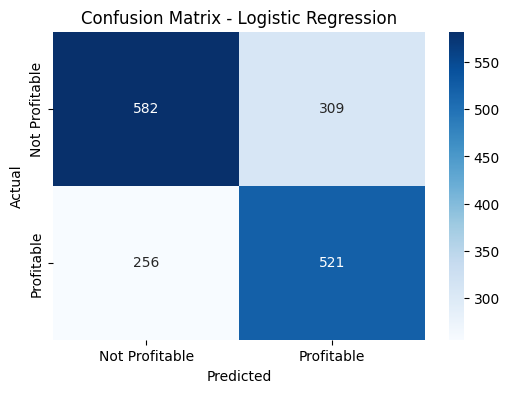


Feature Importance:
              Feature  Coefficient
0      ORDERQUANTITY     0.041839
1           DISCOUNT    -3.029672
2      SHIPPINGCOSTS    -0.016928
3          UNITPRICE     0.001065
4  PRODUCTBASEMARGIN    -2.699367


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
file_path = "/content/ORDERS.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Create target variable: Profitable (1) if profit > 0, else Not Profitable (0)
df["Profitable"] = (df["PROFIT"] > 0).astype(int)

# Selecting features for logistic regression
features = ["ORDERQUANTITY", "DISCOUNT", "SHIPPINGCOSTS", "UNITPRICE", "PRODUCTBASEMARGIN"]
df = df.dropna(subset=features + ["Profitable"])  # Drop rows with missing values

X = df[features]  # Independent variables
y = df["Profitable"]  # Target variable

# Split into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profitable", "Profitable"], yticklabels=["Not Profitable", "Profitable"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Display model coefficients
coefficients = pd.DataFrame({"Feature": features, "Coefficient": model.coef_[0]})
print("\nFeature Importance:\n", coefficients)


In [9]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Load dataset
file_path = "/mnt/data/ORDERS.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Convert ORDERDATE to datetime format
df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")

# Define a reference date (latest transaction date)
reference_date = df["ORDERDATE"].max()

# Group by Customer and Calculate RFM Metrics
rfm = df.groupby("CUSTOMERNAME").agg({
    "ORDERDATE": lambda x: (reference_date - x.max()).days,  # Recency (days since last purchase)
    "ORDERID": "nunique",  # Frequency (number of distinct orders)
    "PROFIT": "sum"  # Monetary value (total profit generated)
})

# Rename columns for clarity
rfm.columns = ["Recency", "Frequency", "MonetaryValue"]

# Filter out one-time buyers (Frequency must be at least 2 for CLV prediction)
rfm = rfm[rfm["Frequency"] > 1]

# Fit the BG/NBD Model (Predicting Purchase Frequency)
bgf = BetaGeoFitter()
bgf.fit(rfm["Frequency"], rfm["Recency"], rfm["MonetaryValue"])

# Predict future transactions for next 6 months
rfm["PredictedPurchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(180, rfm["Frequency"], rfm["Recency"], rfm["MonetaryValue"])

# Fit the Gamma-Gamma Model (Predicting Monetary Value)
ggf = GammaGammaFitter()
ggf.fit(rfm["Frequency"], rfm["MonetaryValue"])

# Predict average transaction value
rfm["ExpectedAverageProfit"] = ggf.conditional_expected_average_profit(rfm["Frequency"], rfm["MonetaryValue"])

# Compute CLV (Customer Lifetime Value)
rfm["CLV"] = ggf.customer_lifetime_value(
    bgf,  # BG/NBD model
    rfm["Frequency"],
    rfm["Recency"],
    rfm["MonetaryValue"],
    time=12,  # Predict CLV for 12 months
    discount_rate=0.01  # 1% monthly discount rate
)

# Sort customers by highest CLV
rfm = rfm.sort_values(by="CLV", ascending=False)

# Display results
import ace_tools as tools
tools.display_dataframe_to_user(name="Customer Lifetime Value (CLV)", dataframe=rfm)

# Plot Top 10 Customers by CLV
plt.figure(figsize=(10, 6))
rfm["CLV"].head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Customers by Predicted CLV")
plt.xlabel("Customer Name")
plt.ylabel("Customer Lifetime Value (CLV)")
plt.xticks(rotation=45)
plt.show()


ModuleNotFoundError: No module named 'lifetimes'

In [10]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Load dataset
file_path = "/content/ORDERS.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Convert ORDERDATE to datetime format
df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")

# Define a reference date (latest transaction date)
reference_date = df["ORDERDATE"].max()

# Group by Customer and Calculate RFM Metrics
rfm = df.groupby("CUSTOMERNAME").agg({
    "ORDERDATE": lambda x: (reference_date - x.max()).days,  # Recency (days since last purchase)
    "ORDERID": "nunique",  # Frequency (number of distinct orders)
    "PROFIT": "sum"  # Monetary value (total profit generated)
})

# Rename columns for clarity
rfm.columns = ["Recency", "Frequency", "MonetaryValue"]

# Filter out one-time buyers (Frequency must be at least 2 for CLV prediction)
rfm = rfm[rfm["Frequency"] > 1]

# Fit the BG/NBD Model (Predicting Purchase Frequency)
bgf = BetaGeoFitter()
bgf.fit(rfm["Frequency"], rfm["Recency"], rfm["MonetaryValue"])

# Predict future transactions for next 6 months
rfm["PredictedPurchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(180, rfm["Frequency"], rfm["Recency"], rfm["MonetaryValue"])

# Fit the Gamma-Gamma Model (Predicting Monetary Value)
ggf = GammaGammaFitter()
ggf.fit(rfm["Frequency"], rfm["MonetaryValue"])

# Predict average transaction value
rfm["ExpectedAverageProfit"] = ggf.conditional_expected_average_profit(rfm["Frequency"], rfm["MonetaryValue"])

# Compute CLV (Customer Lifetime Value)
rfm["CLV"] = ggf.customer_lifetime_value(
    bgf,  # BG/NBD model
    rfm["Frequency"],
    rfm["Recency"],
    rfm["MonetaryValue"],
    time=12,  # Predict CLV for 12 months
    discount_rate=0.01  # 1% monthly discount rate
)

# Sort customers by highest CLV
rfm = rfm.sort_values(by="CLV", ascending=False)

# Display results
import ace_tools as tools
tools.display_dataframe_to_user(name="Customer Lifetime Value (CLV)", dataframe=rfm)

# Plot Top 10 Customers by CLV
plt.figure(figsize=(10, 6))
rfm["CLV"].head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Customers by Predicted CLV")
plt.xlabel("Customer Name")
plt.ylabel("Customer Lifetime Value (CLV)")
plt.xticks(rotation=45)
plt.show()


ModuleNotFoundError: No module named 'lifetimes'

In [11]:
!pip install lifetimes

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter  # Importing necessary classes

# Load dataset
file_path = "/content/ORDERS.csv"  # or "/mnt/data/ORDERS.csv" depending on your file location
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Convert ORDERDATE to datetime format
df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")

# Define a reference date (latest transaction date)
reference_date = df["ORDERDATE"].max()

# Group by Customer and Calculate RFM Metrics
rfm = df.groupby("CUSTOMERNAME").agg({
    "ORDERDATE": lambda x: (reference_date - x.max()).days,  # Recency (days since last purchase)
    "ORDERID": "nunique",  # Frequency (number of distinct orders)
    "PROFIT": "sum"  # Monetary value (total profit generated)
})

# Rename columns for clarity
rfm.columns = ["Recency", "Frequency", "MonetaryValue"]

# Filter out one-time buyers (Frequency must be at least 2 for CLV prediction)
rfm = rfm[rfm["Frequency"] > 1]

# Fit the BG/NBD Model (Predicting Purchase Frequency)
bgf = BetaGeoFitter()
bgf.fit(rfm["Frequency"], rfm["Recency"], rfm["MonetaryValue"])

# Predict future transactions for next 6 months
rfm["PredictedPurchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180, rfm["Frequency"], rfm["Recency"], rfm["MonetaryValue"]
)

# Fit the Gamma-Gamma Model (Predicting Monetary Value)
ggf = GammaGammaFitter()
ggf.fit(rfm["Frequency"], rfm["MonetaryValue"])

# Predict average transaction value
rfm["ExpectedAverageProfit"] = ggf.conditional_expected_average_profit(
    rfm["Frequency"], rfm["MonetaryValue"]
)

# Compute CLV (Customer Lifetime Value)
rfm["CLV"] = ggf.customer_lifetime_value(
    bgf,  # BG/NBD model
    rfm["Frequency"],
    rfm["Recency"],
    rfm["MonetaryValue"],
    time=12,  # Predict CLV for 12 months
    discount_rate=0.01  # 1% monthly discount rate
)

# Sort customers by highest CLV
rfm = rfm.sort_values(by="CLV", ascending=False)

# Display results
# Assuming you have a function 'display_dataframe_to_user' in 'ace_tools'
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Customer Lifetime Value (CLV)", dataframe=rfm)

# Alternatively, you can display the DataFrame using pandas:
print("Customer Lifetime Value (CLV):")
print(rfm)

# Plot Top 10 Customers by CLV
plt.figure(figsize=(10, 6))
rfm["CLV"].head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Customers by Predicted CLV")
plt.xlabel("Customer Name")
plt.ylabel("Customer Lifetime Value (CLV)")
plt.xticks(rotation=45)
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.4 MB/s eta 0:00:00


<ipython-input-11-e27403414c54>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")


ValueError: Some values in recency vector are larger than T vector.

In [14]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Load dataset
file_path = "/content/ORDERS.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Convert ORDERDATE to datetime format
df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")

# Remove rows where ORDERDATE is NaT (missing values)
df = df.dropna(subset=["ORDERDATE"])

# Define a reference date (most recent order date in dataset)
reference_date = df["ORDERDATE"].max()

# Group by Customer and Calculate RFM Metrics
rfm = df.groupby("CUSTOMERNAME").agg({
    "ORDERDATE": [lambda x: (reference_date - x.min()).days,  # Customer Age (T) - days since first purchase
                  lambda x: (reference_date - x.max()).days],  # Recency (days since last purchase)
    "ORDERID": "nunique",  # Frequency (number of distinct orders)
    "PROFIT": "sum"  # Monetary value (total profit generated)
})

# Rename columns for clarity
rfm.columns = ["Customer_Age", "Recency", "Frequency", "MonetaryValue"]

# Remove customers who purchased only once (BG/NBD model requires Frequency ≥ 1)
rfm = rfm[rfm["Frequency"] > 1]

# Fit the BG/NBD Model (Predicting Purchase Frequency)
bgf = BetaGeoFitter()
bgf.fit(rfm["Frequency"], rfm["Recency"], rfm["Customer_Age"])

# Predict future transactions for the next 6 months
rfm["PredictedPurchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180, rfm["Frequency"], rfm["Recency"], rfm["Customer_Age"]
)

# Fit the Gamma-Gamma Model (Predicting Monetary Value)
ggf = GammaGammaFitter()
ggf.fit(rfm["Frequency"], rfm["MonetaryValue"])

# Predict average transaction value
rfm["ExpectedAverageProfit"] = ggf.conditional_expected_average_profit(
    rfm["Frequency"], rfm["MonetaryValue"]
)

# Compute CLV (Customer Lifetime Value)
rfm["CLV"] = ggf.customer_lifetime_value(
    bgf,  # BG/NBD model
    rfm["Frequency"],
    rfm["Recency"],
    rfm["Customer_Age"],
    time=12,  # Predict CLV for 12 months
    discount_rate=0.01  # 1% monthly discount rate
)

# Sort customers by highest CLV
rfm = rfm.sort_values(by="CLV", ascending=False)

# Display results
import ace_tools as tools
tools.display_dataframe_to_user(name="Customer Lifetime Value (CLV)", dataframe=rfm)

# Plot Top 10 Customers by CLV
plt.figure(figsize=(10, 6))
rfm["CLV"].head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Customers by Predicted CLV")
plt.xlabel("Customer Name")
plt.ylabel("Customer Lifetime Value (CLV)")
plt.xticks(rotation=45)
plt.show()


<ipython-input-14-a0d873518ea9>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -21.529798709886567
        x: [-7.058e-01 -6.152e+00  1.554e+01  1.740e+01]
      nit: 33
      jac: [-1.485e-05  4.894e-06  8.806e-06 -8.821e-06]
 hess_inv: [[ 1.464e+00  1.964e+00  2.473e+03  2.472e+03]
            [ 1.964e+00  4.950e+00  1.129e+03  1.129e+03]
            [ 2.473e+03  1.129e+03  4.108e+07  4.108e+07]
            [ 2.472e+03  1.129e+03  4.108e+07  4.108e+07]]
     nfev: 77
     njev: 61


ConvergenceError: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.


In [16]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Load dataset
file_path = "/content/ORDERS.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Convert ORDERDATE to datetime format
df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")

# Remove rows where ORDERDATE is NaT (missing values)
df = df.dropna(subset=["ORDERDATE"])

# Define a reference date (most recent order date in dataset)
reference_date = df["ORDERDATE"].max()

# Group by Customer and Calculate RFM Metrics
rfm = df.groupby("CUSTOMERNAME").agg({
    "ORDERDATE": [lambda x: (reference_date - x.min()).days,  # Customer Age (T) - days since first purchase
                  lambda x: (reference_date - x.max()).days],  # Recency (days since last purchase)
    "ORDERID": "nunique",  # Frequency (number of distinct orders)
    "PROFIT": "sum"  # Monetary value (total profit generated)
})

# Rename columns for clarity
rfm.columns = ["Customer_Age", "Recency", "Frequency", "MonetaryValue"]

# Remove customers who purchased only once (BG/NBD model requires Frequency ≥ 1)
rfm = rfm[rfm["Frequency"] > 1]

# Ensure Monetary Values are Positive
rfm = rfm[rfm["MonetaryValue"] > 0]

# Apply a Penalizer to Stabilize the BG/NBD Model
bgf = BetaGeoFitter(penalizer_coef=0.01)  # Adding penalization to prevent convergence issues
bgf.fit(rfm["Frequency"], rfm["Recency"], rfm["Customer_Age"])

# Predict future transactions for the next 6 months
rfm["PredictedPurchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180, rfm["Frequency"], rfm["Recency"], rfm["Customer_Age"]
)

# Fit the Gamma-Gamma Model (Predicting Monetary Value)
ggf = GammaGammaFitter()
ggf.fit(rfm["Frequency"], rfm["MonetaryValue"])

# Predict average transaction value
rfm["ExpectedAverageProfit"] = ggf.conditional_expected_average_profit(
    rfm["Frequency"], rfm["MonetaryValue"]
)

# Compute CLV (Customer Lifetime Value)
rfm["CLV"] = ggf.customer_lifetime_value(
    bgf,  # BG/NBD model
    rfm["Frequency"],
    rfm["Recency"],
    rfm["Customer_Age"],
    time=12,  # Predict CLV for 12 months
    discount_rate=0.01  # 1% monthly discount rate
)

# Sort customers by highest CLV
rfm = rfm.sort_values(by="CLV", ascending=False)

# Display results
import ace_tools as tools
tools.display_dataframe_to_user(name="Customer Lifetime Value (CLV)", dataframe=rfm)

# Plot Top 10 Customers by CLV
plt.figure(figsize=(10, 6))
rfm["CLV"].head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Customers by Predicted CLV")
plt.xlabel("Customer Name")
plt.ylabel("Customer Lifetime Value (CLV)")
plt.xticks(rotation=45)
plt.show()


<ipython-input-16-3a9258b5cee4>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")


TypeError: GammaGammaFitter.customer_lifetime_value() missing 1 required positional argument: 'monetary_value'

In [17]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Load dataset
file_path = "/content/ORDERS.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Convert ORDERDATE to datetime format
df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")

# Remove rows where ORDERDATE is NaT (missing values)
df = df.dropna(subset=["ORDERDATE"])

# Define a reference date (most recent order date in dataset)
reference_date = df["ORDERDATE"].max()

# Group by Customer and Calculate RFM Metrics
rfm = df.groupby("CUSTOMERNAME").agg({
    "ORDERDATE": [lambda x: (reference_date - x.min()).days,  # Customer Age (T) - days since first purchase
                  lambda x: (reference_date - x.max()).days],  # Recency (days since last purchase)
    "ORDERID": "nunique",  # Frequency (number of distinct orders)
    "PROFIT": "sum"  # Monetary value (total profit generated)
})

# Rename columns for clarity
rfm.columns = ["Customer_Age", "Recency", "Frequency", "MonetaryValue"]

# Remove customers who purchased only once (BG/NBD model requires Frequency ≥ 1)
rfm = rfm[rfm["Frequency"] > 1]

# Ensure Monetary Values are Positive
rfm = rfm[rfm["MonetaryValue"] > 0]

# Apply a Penalizer to Stabilize the BG/NBD Model
bgf = BetaGeoFitter(penalizer_coef=0.01)  # Adding penalization to prevent convergence issues
bgf.fit(rfm["Frequency"], rfm["Recency"], rfm["Customer_Age"])

# Predict future transactions for the next 6 months
rfm["PredictedPurchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180, rfm["Frequency"], rfm["Recency"], rfm["Customer_Age"]
)

# Fit the Gamma-Gamma Model (Predicting Monetary Value)
ggf = GammaGammaFitter()
ggf.fit(rfm["Frequency"], rfm["MonetaryValue"])

# Predict average transaction value
rfm["ExpectedAverageProfit"] = ggf.conditional_expected_average_profit(
    rfm["Frequency"], rfm["MonetaryValue"]
)

# Compute CLV (Customer Lifetime Value) - FIXED MONETARY VALUE PARAMETER
rfm["CLV"] = ggf.customer_lifetime_value(
    bgf,  # BG/NBD model
    rfm["Frequency"],
    rfm["Recency"],
    rfm["Customer_Age"],
    rfm["MonetaryValue"],  # <-- FIXED: Pass the missing monetary_value parameter
    time=12,  # Predict CLV for 12 months
    discount_rate=0.01  # 1% monthly discount rate
)

# Sort customers by highest CLV
rfm = rfm.sort_values(by="CLV", ascending=False)

# Display results
import ace_tools as tools
tools.display_dataframe_to_user(name="Customer Lifetime Value (CLV)", dataframe=rfm)

# Plot Top 10 Customers by CLV
plt.figure(figsize=(10, 6))
rfm["CLV"].head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Customers by Predicted CLV")
plt.xlabel("Customer Name")
plt.ylabel("Customer Lifetime Value (CLV)")
plt.xticks(rotation=45)
plt.show()


<ipython-input-17-eaa4b4f57d6d>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")


ModuleNotFoundError: No module named 'ace_tools'

In [19]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter

# Load dataset
file_path = "/content/ORDERS.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Convert ORDERDATE to datetime format
df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")

# Remove rows with missing order dates
df = df.dropna(subset=["ORDERDATE"])

# Define a reference date (most recent order date in dataset)
reference_date = df["ORDERDATE"].max()

# Group by Customer and Calculate Churn Metrics
churn_data = df.groupby("CUSTOMERNAME").agg({
    "ORDERDATE": [lambda x: (x.max() - x.min()).days,  # Customer Tenure (T) - Days between first & last purchase
                  lambda x: (reference_date - x.max()).days],  # Time since last purchase
    "ORDERID": "nunique",  # Purchase Frequency
    "PROFIT": "sum",  # Total Monetary Value
    "DISCOUNT": "mean",  # Average Discount Usage
    "SHIPPINGCOSTS": "mean"  # Average Shipping Cost
})

# Rename columns for clarity
churn_data.columns = ["Customer_Tenure", "Time_Since_Last_Purchase", "Frequency", "MonetaryValue", "Avg_Discount", "Avg_Shipping_Cost"]

# Define Churn (1 if no purchase in last 180 days, else 0)
churn_data["Churned"] = (churn_data["Time_Since_Last_Purchase"] > 180).astype(int)

# Prepare Data for Cox Proportional Hazard Model
cox_data = churn_data.drop(columns=["Time_Since_Last_Purchase"])  # Drop to avoid multicollinearity

# Fit the Cox Proportional Hazard Model
cph = CoxPHFitter()
cph.fit(cox_data, duration_col="Customer_Tenure", event_col="Churned")

# Print Summary of Model
cph.print_summary()

# Plot Survival Curve for Top 10 Customers
plt.figure(figsize=(10, 6))
cph.plot()
plt.title("Cox Proportional Hazard Model - Impact of Features on Churn")
plt.show()

# Predict Churn Risk for Customers
churn_data["Churn_Risk"] = cph.predict_partial_hazard(cox_data)

# Display top customers with highest churn risk
import ace_tools as tools
tools.display_dataframe_to_user(name="Customer Churn Risk", dataframe=churn_data.sort_values(by="Churn_Risk", ascending=False))

# Plot Top 10 Customers at Highest Churn Risk
plt.figure(figsize=(10, 6))
churn_data["Churn_Risk"].head(10).plot(kind="bar", color="red")
plt.title("Top 10 Customers at Highest Churn Risk")
plt.xlabel("Customer Name")
plt.ylabel("Churn Risk Score")
plt.xticks(rotation=45)
plt.show()


ModuleNotFoundError: No module named 'lifelines'

In [20]:
pip install lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=0a593a3c15fe12ac804b48e99e222b5e80e2e476562681b7d6651f8dae4f5cc2
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


<ipython-input-23-cc2f6020d36c>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")


<lifelines.CoxPHFitter: fitted with 795 total observations, 434 right-censored observations>
             duration col = 'Customer_Tenure'
                event col = 'Churned'
      baseline estimation = breslow
   number of observations = 795
number of events observed = 361
   partial log-likelihood = -2130.55
         time fit was run = 2025-02-10 06:40:08 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
Frequency          -0.29      0.75      0.02           -0.33           -0.24                0.72                0.78
MonetaryValue       0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Avg_Discount      -14.94      0.00      4.29          -23.35           -6.53                0.00                0.00
Avg_Shipping_Cost  -0.02      0.98      0.01           -0.03            0.00                0.97                1.00

                   cmp to      z      p  -log2(p)
covariate                                        
Frequency            0.00 -12.60 <0.005    118.52
MonetaryValue        0.00   1.17   0.24      2.05
Avg_Discount         0.00  -3.48 <0.005     10.97
Avg_Shipping_Cost    0.00  -1.73   0.08      3.59
---
Concordance = 0.76
Partial AIC = 4269.11
log-likelihood ratio test = 240.79 on 4 df
-log2(p) of ll-ratio test = 166.77

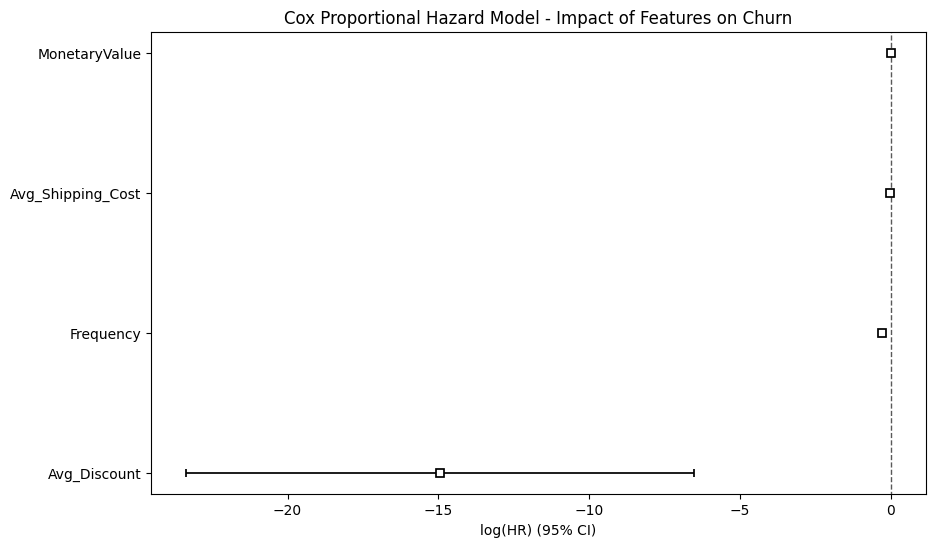

ModuleNotFoundError: No module named 'ace_tools'

In [23]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter

# Load dataset
file_path = "/content/ORDERS.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Convert ORDERDATE to datetime format
df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")

# Remove rows with missing order dates
df = df.dropna(subset=["ORDERDATE"])

# Define a reference date (most recent order date in dataset)
reference_date = df["ORDERDATE"].max()

# Group by Customer and Calculate Churn Metrics
churn_data = df.groupby("CUSTOMERNAME").agg({
    "ORDERDATE": [lambda x: (x.max() - x.min()).days,  # Customer Tenure (T) - Days between first & last purchase
                  lambda x: (reference_date - x.max()).days],  # Time since last purchase
    "ORDERID": "nunique",  # Purchase Frequency
    "PROFIT": "sum",  # Total Monetary Value
    "DISCOUNT": "mean",  # Average Discount Usage
    "SHIPPINGCOSTS": "mean"  # Average Shipping Cost
})

# Rename columns for clarity
churn_data.columns = ["Customer_Tenure", "Time_Since_Last_Purchase", "Frequency", "MonetaryValue", "Avg_Discount", "Avg_Shipping_Cost"]

# Define Churn (1 if no purchase in last 180 days, else 0)
churn_data["Churned"] = (churn_data["Time_Since_Last_Purchase"] > 180).astype(int)

# Prepare Data for Cox Proportional Hazard Model
cox_data = churn_data.drop(columns=["Time_Since_Last_Purchase"])  # Drop to avoid multicollinearity

# Fit the Cox Proportional Hazard Model
cph = CoxPHFitter()
cph.fit(cox_data, duration_col="Customer_Tenure", event_col="Churned")

# Print Summary of Model
cph.print_summary()

# Plot Survival Curve for Top 10 Customers
plt.figure(figsize=(10, 6))
cph.plot()
plt.title("Cox Proportional Hazard Model - Impact of Features on Churn")
plt.show()

# Predict Churn Risk for Customers
churn_data["Churn_Risk"] = cph.predict_partial_hazard(cox_data)

# Display top customers with highest churn risk
import ace_tools as tools
tools.display_dataframe_to_user(name="Customer Churn Risk", dataframe=churn_data.sort_values(by="Churn_Risk", ascending=False))

# Plot Top 10 Customers at Highest Churn Risk
plt.figure(figsize=(10, 6))
churn_data["Churn_Risk"].head(10).plot(kind="bar", color="red")
plt.title("Top 10 Customers at Highest Churn Risk")
plt.xlabel("Customer Name")
plt.ylabel("Churn Risk Score")
plt.xticks(rotation=45)
plt.show()


In [24]:
# Display top customers with highest churn risk
#import ace_tools as tools #Comment this line since the module was not found.
#tools.display_dataframe_to_user(name="Customer Churn Risk", dataframe=churn_data.sort_values(by="Churn_Risk", ascending=False)) # Comment this line since ace_tools is not available

# Instead, just print the churn_data DataFrame for now:
print(churn_data.sort_values(by="Churn_Risk", ascending=False)) # This line will display the DataFrame sorted by churn risk.

                   Customer_Tenure  Time_Since_Last_Purchase  Frequency  \
CUSTOMERNAME                                                              
Maureen Grace                    0                       946          1   
Maria Etezadi                    0                      1242          1   
Dorothy Dickinson                0                       968          1   
Anne McFarland                 405                       304          2   
Mark Hamilton                    0                       384          1   
...                            ...                       ...        ...   
Carlos Soltero                1382                        61         20   
Jack O'Briant                 1312                        67         21   
Ed Braxton                    1399                        23         22   
Brad Thomas                   1357                         3         24   
Darren Budd                   1409                        46         26   

                   Monet

In [ ]:
!ls /mnt/data/ORDERS.csv


ls: cannot access '/mnt/data/ORDERS.csv': No such file or directory


In [ ]:
file_path = "/path/to/your/ORDERS.csv"  # Replace with the correct path
    df = pd.read_csv(file_path, encoding="ISO-8859-1")

IndentationError: unexpected indent (<ipython-input-5-00c7340bab4c>, line 2)

<ipython-input-7-fafcfd015c00>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')
<ipython-input-7-fafcfd015c00>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['SHIPDATE'] = pd.to_datetime(df['SHIPDATE'], errors='coerce')


Mean Absolute Error: 1299.5343057704677
Mean Squared Error: 6081694.243554544
R-Squared Score: 0.4876709744608452


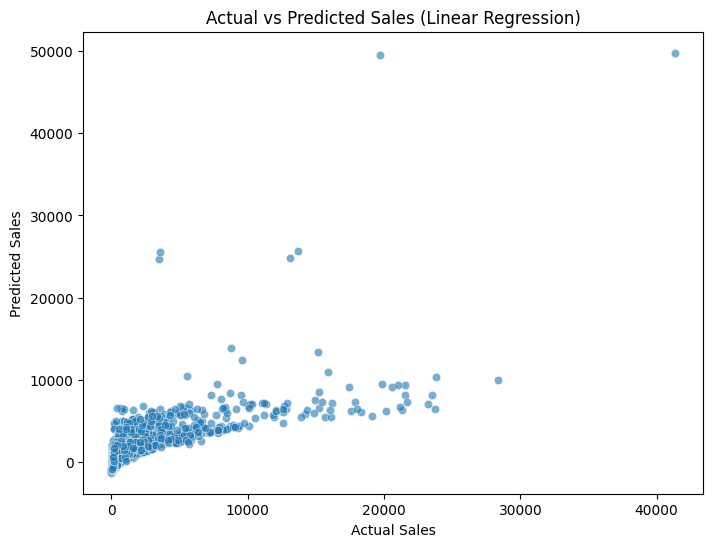

             Feature  Coefficient
0      ORDERQUANTITY    70.157001
1           DISCOUNT -2129.936180
2      SHIPPINGCOSTS    60.443878
3          UNITPRICE     7.269828
4  PRODUCTBASEMARGIN   259.094071


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
file_path = "/content/ORDERS.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Convert ORDERDATE and SHIPDATE to datetime
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')
df['SHIPDATE'] = pd.to_datetime(df['SHIPDATE'], errors='coerce')

# Selecting features for regression
features = ["ORDERQUANTITY", "DISCOUNT", "SHIPPINGCOSTS", "UNITPRICE", "PRODUCTBASEMARGIN"]
df = df.dropna(subset=features + ["SALES"])  # Drop rows with missing values

X = df[features]  # Independent variables
y = df["SALES"]   # Dependent variable (target)

# Split into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model performance
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-Squared Score:", r2_score(y_test, y_pred))

# Visualizing actual vs predicted sales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales (Linear Regression)")
plt.show()

# Display model coefficients
coefficients = pd.DataFrame({"Feature": features, "Coefficient": model.coef_})
print(coefficients)
